In [4]:
%load_ext autoreload
%autoreload 2


In [5]:
import librosa
import librosa.display
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import sys

np.set_printoptions(threshold=sys.maxsize, suppress=True)


In [6]:
import IPython

recording_file = "samples/record.wav"
music_file = "samples/music.wav"

recording, sr = librosa.load(recording_file, sr=11_025)
music, sr = librosa.load(music_file, sr=11_025)

IPython.display.Audio(recording_file)


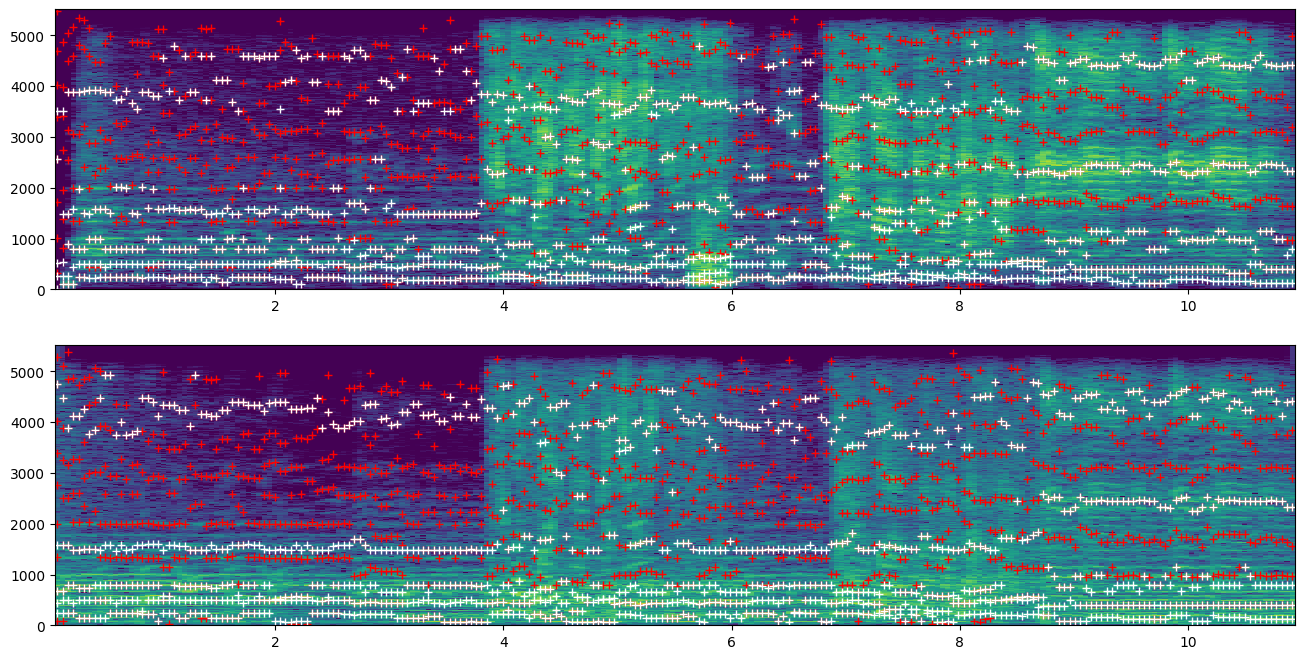

In [7]:
from freq.prominence import get_peak_frequencies_prominence as prominence
from freq.bands import get_peak_frequencies_bands as bands
from util.draw import draw_filtered

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

music_offset = int(sr * 4.25)
music_sample = music[music_offset : music_offset + recording.shape[-1]]

draw_filtered(
    recording,
    [
        (prominence, {"marker": "+", "c": "r"}),
        (bands, {"marker": "+", "c": "w"}),
    ],
    sr=11_025,
    fig=axs[0],
)

draw_filtered(
    music_sample,
    [
        (prominence, {"marker": "+", "c": "r"}),
        (bands, {"marker": "+", "c": "w"}),
    ],
    sr=11_025,
    fig=axs[1],
)

IPython.display.Audio(data=music_sample, rate=sr)


In [8]:
from hash.cluster import get_hashes_from_peaks_cluster as cluster
from hash.fanout import get_hashes_from_peaks_fanout as fanout
from freq.prominence import get_peak_frequencies_prominence as prominence
from freq.bands import get_peak_frequencies_bands as bands
from util.compare import compare_fingerprints

# Tyto konstanty (krom sr?) bych už dále neměnil,
# Downsampling vychází z původního články, smázne zbytečný šum
global_params = {"sr": 11_025, "n_fft": 2048, "hop_length": 2048 // 4}

bands_params = {"avg_window": 10, **global_params}

prominence_params = {
    "num_peaks": 15,
    "distance": 100,
    **global_params,
}

cluster_kwargs = {"window_size": 3, "gap_size": 1}

fanout_kwargs = {"fan_out": 50, "tail_size": 1}

record, _ = librosa.load(recording_file, sr=global_params["sr"])
music, _ = librosa.load(music_file, sr=global_params["sr"])

music_prominence = prominence(music, **prominence_params)
record_prominence = prominence(record, **prominence_params)

music_bands = bands(music, **bands_params)
record_bands = bands(record, **bands_params)

data = {
    "cluster": {
        "prominence": compare_fingerprints(
            cluster(music_prominence, **cluster_kwargs),
            cluster(record_prominence, **cluster_kwargs),
        )[0],
        "bands": compare_fingerprints(
            cluster(music_bands, **cluster_kwargs),
            cluster(record_bands, **cluster_kwargs),
        )[0],
    },
    "fanout": {
        "prominence": compare_fingerprints(
            fanout(music_prominence, **fanout_kwargs),
            fanout(record_prominence, **fanout_kwargs),
        )[0],
        "bands": compare_fingerprints(
            fanout(music_bands, **fanout_kwargs), fanout(record_bands, **fanout_kwargs)
        )[0],
    },
}

pd.concat({k: pd.DataFrame(v) for k, v in data.items()})




prominence     bands
cluster songId      <none>    <none>
        matches         41        53
        ratio      0.02497  0.045377
fanout  songId      <none>    <none>
        matches       2255      2154
        ratio     0.035859  0.061009